# Medication prevalence
The purpose of this notebook is to rank the diabetes medications of interest by their prevalence in patients' primary-care records.

Install packages.

In [1]:
#######################
## Install packages. ##
#######################
library( bigrquery )
library( ggplot2 )
library( tidyverse )
library( readr )

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Set and load requisites.

In [2]:
##############################
## Set and load requisites. ##
##############################

# Setup connection to GCP.
project_id = "yhcr-prd-phm-bia-core"
con <- DBI::dbConnect( drv = bigquery(), project = project_id )

# Define R tibbles from GCP tables.
r_tbl_srcode <- dplyr::tbl( con, "CB_FDM_PrimaryCare_V7.tbl_srcode" )
r_tbl_BNF_DMD_SNOMED_lkp <- dplyr::tbl( con, "CB_LOOKUPS.tbl_BNF_DMD_SNOMED_lkp" )
r_tbl_srprimarycaremedication <- dplyr::tbl( con, "CB_FDM_PrimaryCare_V7.tbl_srprimarycaremedication" )

# Clinical code lists (BNF, SNOMED-CT, etc).
codes_SNOMED_test_of_interest <-
    readr::read_csv(file = 'opensafely-glycated-haemoglobin-hba1c-tests-3e5b1269.csv',
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_BNF_meds_of_interest <-
    readr::read_csv(file = 'ciaranmci-bnf-section-61-drugs-for-diabetes-207573b7.csv',
                    col_types = cols( code = col_character(), term = col_character() ) )$code
names_meds_of_interest <-
    r_tbl_BNF_DMD_SNOMED_lkp %>%
    dplyr::filter( BNF_Code %in% codes_BNF_meds_of_interest ) %>%
    dplyr::select( DMplusD_ProductDescription )

Warning message:
“<BigQueryConnection> uses an old dbplyr interface
ℹ Please install a newer version of the package or contact the maintainer
This warning is displayed once every 8 hours.”


Rank medications of interest for their prevalence among patients. A medication is counted once for each patient if the patient has been prescribed it.

In [18]:
qry %>%
    dplyr::filter( !is.na( count_records_per_medication ) ) %>% 
    dbplyr::window_order( count_records_per_medication ) %>%
    dplyr::filter( row_number() >= ( n() - 10 ) ) %>%
    dplyr::arrange( count_records_per_medication ) %>% collect()

nameofmedication,medicationquantity,medicationdosage,count_records_per_medication
<chr>,<chr>,<chr>,<int>
Metformin 500mg tablets,84 tablet,take one 3 times/day,104340
Canagliflozin 100mg tablets,30 tablet,take one daily,115053
Empagliflozin 10mg tablets,28 tablet,take one daily,124302
Metformin 850mg tablets,56 tablet,take one twice daily,141676
Sitagliptin 100mg tablets,28 tablets,take one daily,149520
Linagliptin 5mg tablets,7 tablet,take one daily,165567
Metformin 850mg tablets,56 tablets,take one twice daily,177912
Sitagliptin 100mg tablets,7 tablet,take one daily,193854
Linagliptin 5mg tablets,28 tablet,take one daily,228321


nameofmedication,medicationquantity,medicationdosage,count_records_per_medication
<chr>,<chr>,<chr>,<int>
Metformin 500mg tablets,84 tablet,take one 3 times/day,104340
Canagliflozin 100mg tablets,30 tablet,take one daily,115053
Empagliflozin 10mg tablets,28 tablet,take one daily,124302
Metformin 850mg tablets,56 tablet,take one twice daily,141676
Sitagliptin 100mg tablets,28 tablets,take one daily,149520
Linagliptin 5mg tablets,7 tablet,take one daily,165567
Metformin 850mg tablets,56 tablets,take one twice daily,177912
Sitagliptin 100mg tablets,7 tablet,take one daily,193854
Linagliptin 5mg tablets,28 tablet,take one daily,228321


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


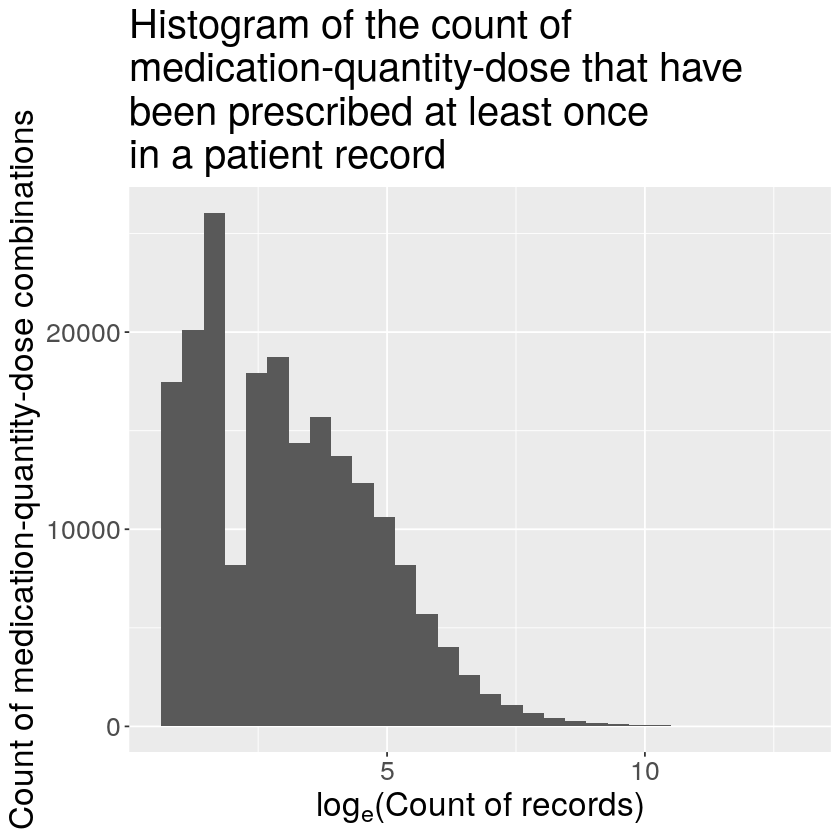

In [21]:
qry <-
    r_tbl_srprimarycaremedication %>%
    # Select every record that has a prescription for any diabetes medication.
    dplyr::inner_join( names_meds_of_interest, by = join_by( nameofmedication == DMplusD_ProductDescription ) ) %>%
    # Tally how many patients have ever been prescribed each medication.
    dplyr::select( person_id, nameofmedication, medicationquantity, medicationdosage ) %>%
    dplyr::summarise( count_records_per_medication = n(), .by = c( nameofmedication, medicationquantity, medicationdosage ) )

top_10 <-
    qry %>%
    dplyr::filter( !is.na( count_records_per_medication ) ) %>% 
    dbplyr::window_order( count_records_per_medication ) %>%
    dplyr::filter( row_number() >= ( n() - 10 ) ) %>%
    dplyr::arrange( count_records_per_medication ) %>%
    dplyr::collect()
top_10

plot_histogram <-
    qry %>%
    ggplot2::ggplot() +
        geom_histogram( aes( x = log( count_records_per_medication ) ) ) +
        labs( title = "Histogram of the count of\nmedication-quantity-dose that have\nbeen prescribed at least once\nin a patient record" ) +
        xlab( base::expression( log[e]*"(Count of records)" ) ) +
        ylab( "Count of medication-quantity-dose combinations" ) +
        theme( text = element_text( size = 20 ) )
plot_histogram